<a href="https://colab.research.google.com/github/waelrash1/forecastingmodelsPY/blob/main/CH07/CH07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting non-stationary time series

This chapter covers
* Examining the autoregressive integrated moving average model, or $ARIMA(p,d,q)$
* Applying the general modeling procedure for nonstationary time series
* Forecasting using the $ARIMA(p,d,q)$ model

# Defining the autoregressive integrated moving average model ARIMA

* An autoregressive integrated moving average process is the combination of an autoregressive
process $AR(p)$, integration $I(d)$, and the moving average process $MA(q)$.

* Just like the $ARMA$ process, the $ARIMA$ process states that the present value is
dependent on past values, coming from the $ AR(p)$ portion, and past errors, coming
from the $MA(q)$ portion.

* However, instead of using the original series, denoted as $y_t$,
the $ARIMA$ process uses the differenced series, denoted as $y'_t$. Note that $y'_t$ can represent a series that has been differenced more than once.

Integration is the reverse of differencing, and the order of integration $d$ is equal to the
number of times the series has been differenced to be rendered stationary.
The general equation of the $ARIMA(p,d,q)$ process is
$$
\Large y'_t = C + \phi_1 y'_{t–1} +⋅⋅⋅ + \phi_p y'_{t–p} + \theta_1 \epsilon'_{t–1} +⋅⋅⋅+ \theta_q \epsilon'_{t–q} + \theta_t
$$

Note that $y'_t$ represents the differenced series, and it may have been differenced
more than once.

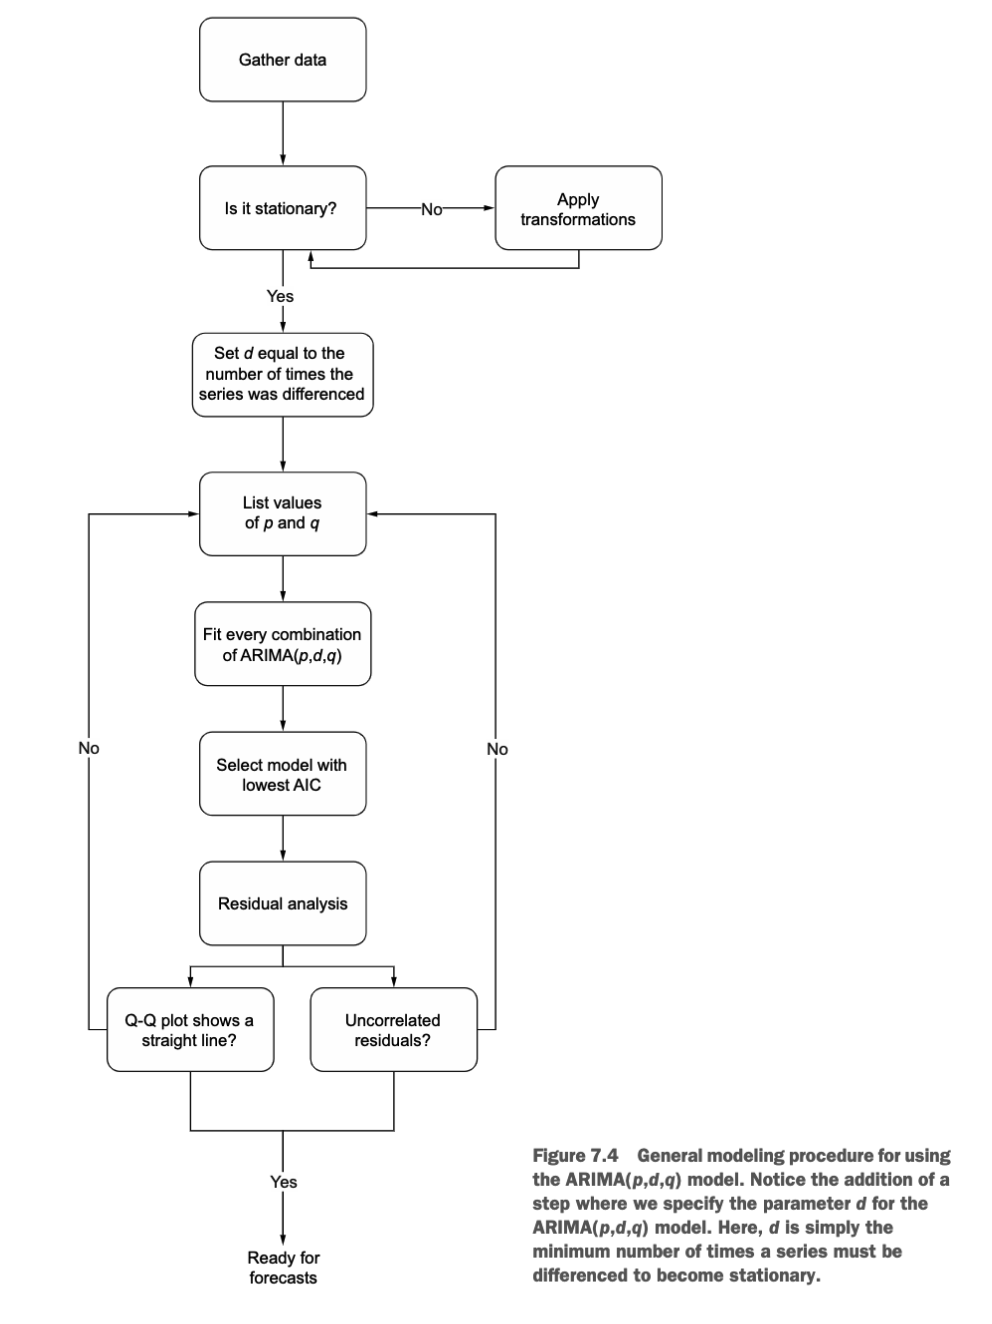![Screenshot 2023-03-25 at 17.45.29.png](attachment:15cbfa8e-912f-499a-a720-0c033d245dc5.png)

# Forecasting a non-stationary times series

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:

data_url='https://raw.githubusercontent.com/waelrash1/timeSeriesPy/master/data/jj.csv'

df = pd.read_csv(data_url)

df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


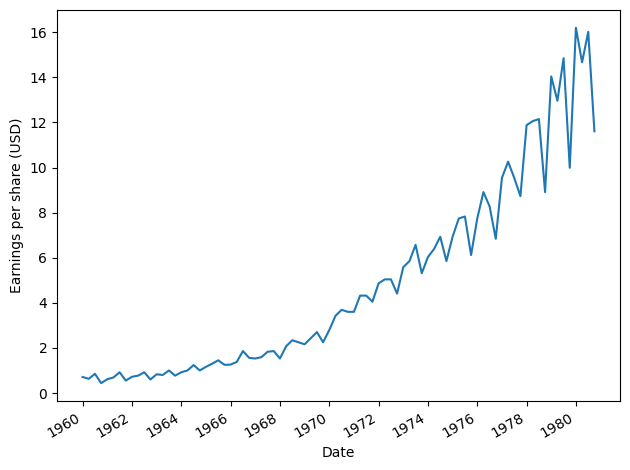

In [4]:
fig, ax = plt.subplots()

ax.plot(df.date, df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH07_F02_peixeiro.png', dpi=300)

In [5]:
ad_fuller_result = adfuller(df['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.7420165734574744
p-value: 1.0


In [7]:
eps_diff = np.diff(df['data'], n=1)

ad_fuller_result = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.40740976363804615
p-value: 0.9088542416911305


In [8]:
eps_diff2 = np.diff(eps_diff, n=1)

ad_fuller_result = adfuller(eps_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.585162874793155
p-value: 0.006051099869603682


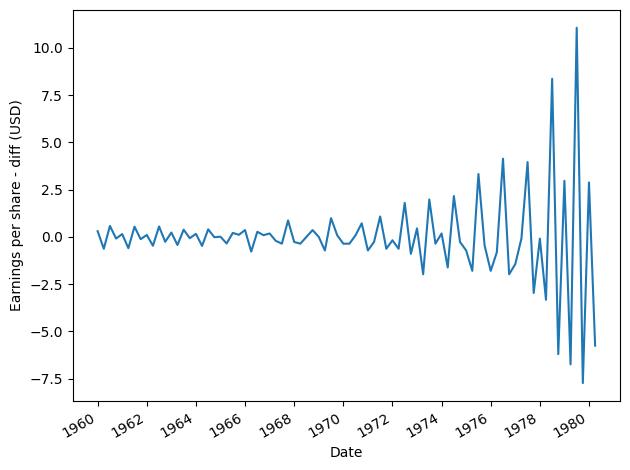

In [9]:
fig, ax = plt.subplots()

ax.plot(df['date'][2:], eps_diff2)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH07_F01_peixeiro.png', dpi=300)

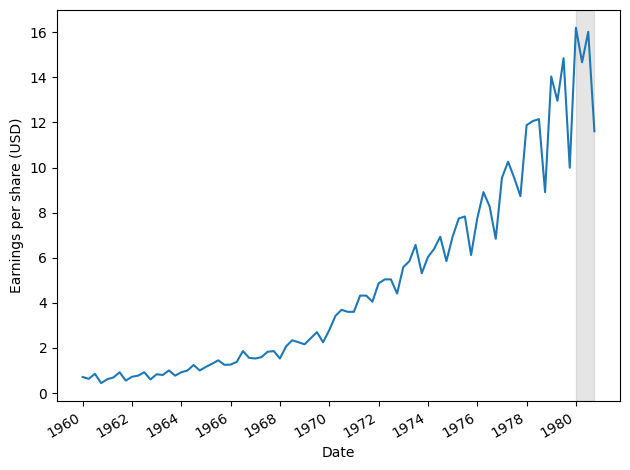

In [10]:
fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH07_F06_peixeiro.png', dpi=300)

In [11]:
def optimize_ARIMA(training_data, order_list, d) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(training_data, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        bic= model.bic
        results.append([order, aic, bic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC','BIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [12]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 2

order_list = list(product(ps, qs))
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [13]:
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [14]:
train = df['data'][:-4]

result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC,BIC
0,"(3, 3)",115.266637,131.763599
1,"(3, 1)",115.624980,127.408525
2,"(3, 2)",115.672007,129.812260
3,"(3, 0)",154.430625,163.857460
4,"(0, 3)",194.654716,204.081552
5,"(0, 2)",209.274868,216.344995
6,"(2, 3)",220.666965,234.807218
7,"(1, 3)",228.267730,240.051274
8,"(1, 2)",228.935782,238.362618
9,"(2, 2)",229.974691,241.758235


In [15]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   80
Model:               SARIMAX(3, 2, 3)   Log Likelihood                 -50.633
Date:                Sun, 10 Mar 2024   AIC                            115.267
Time:                        22:43:27   BIC                            131.764
Sample:                             0   HQIC                           121.871
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9994      0.037    -26.764      0.000      -1.073      -0.926
ar.L2         -0.9882      0.040    -25.002      0.000      -1.066      -0.911
ar.L3         -0.9758      0.026    -37.598      0.0

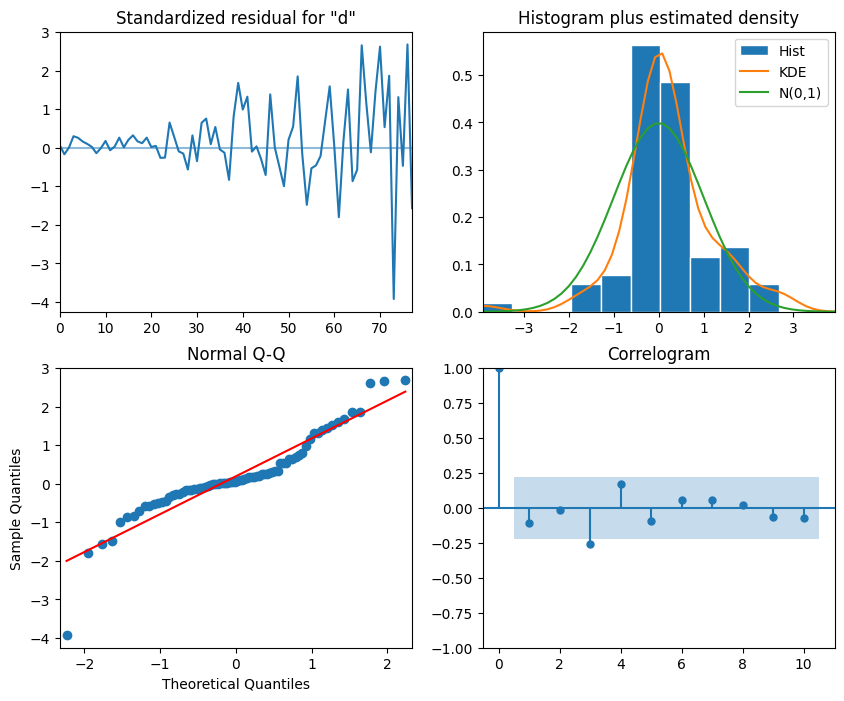

In [16]:
model_fit.plot_diagnostics(figsize=(10,8));

plt.savefig('figures/CH07_F07_peixeiro.png', dpi=300)

In [17]:
from statsmodels.stats.diagnostic import acorr_ljungbox


residuals = model_fit.resid


acorr_ljungbox(residuals, np.arange(1, 11, 1))



,lb_stat,lb_pvalue
1,1.652020,0.198684
2,1.654544,0.437241
3,7.276173,0.063597
4,9.231226,0.055573
5,9.853425,0.079497
6,10.097125,0.120621
7,10.346926,0.169751
8,10.379005,0.239426
9,10.721222,0.295303
10,11.159917,0.345196


In [18]:
test = df.iloc[-4:]

test['naive_seasonal'] = df['data'].iloc[76:80].values
test

,date,data,naive_seasonal
80,1980-01-01,16.20,14.04
81,1980-04-01,14.67,12.96
82,1980-07-02,16.02,14.85
83,1980-10-01,11.61,9.99


In [19]:
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

,date,data,naive_seasonal,ARIMA_pred
80,1980-01-01,16.20,14.04,15.858693
81,1980-04-01,14.67,12.96,14.381508
82,1980-07-02,16.02,14.85,16.365509
83,1980-10-01,11.61,9.99,11.680906


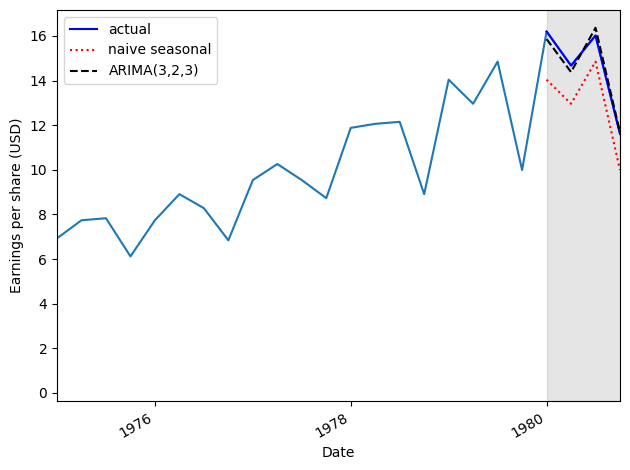

In [20]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH07_F08_peixeiro.png', dpi=300)

In [21]:

from sklearn.metrics import mean_absolute_percentage_error as mape

mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])*100
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])*100

print('MAPE Naive:',"%.2f" % (mape_naive_seasonal),'%')
print('MAPE ARIMA:',"%.2f" % (mape_ARIMA),'%')


MAPE Naive: 11.56 %
MAPE ARIMA: 1.71 %


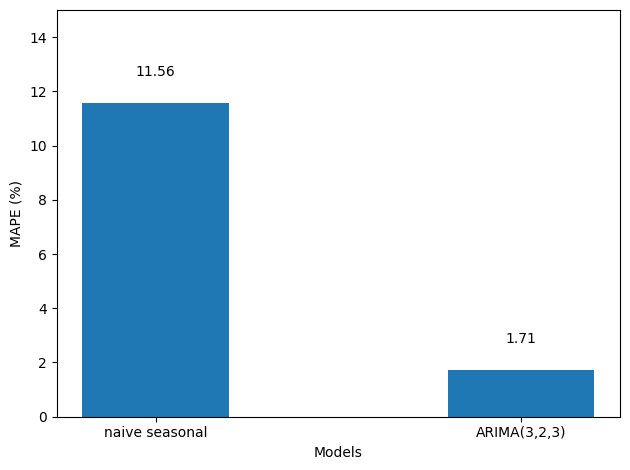

In [22]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH07_F09_peixeiro.png', dpi=300)